# Importing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
acc_file_paths = sorted(glob.glob('/content/drive/MyDrive/Implementation/watch/accel/*'))
gyro_file_paths = sorted(glob.glob('/content/drive/MyDrive/Implementation/watch/gyro/*'))

In [ ]:
# A dictionary will be used to store the read dataset
# key = subject_id. values = list of shape (2, 17, 200, 6)
WISDM = {}

## Formatting and Segementing into 10-second instances

In [ ]:
def format_and_segment_data(acc_data, gyro_data):
    def round_to_10_seconds(timestamp):
        return timestamp - (timestamp % 10**10)  # 10 seconds in nanoseconds

    def format_data(raw_data):
        formatted_data = []
        for entry in raw_data:
            split_entry = entry[:-1].split(',')
            split_entry[2] = int(split_entry[2])
            for index in range(3, len(split_entry)):
                split_entry[index] = float(split_entry[index])
            formatted_data.append(split_entry)
        return formatted_data

    def segment_data(formatted_data):
        segmented_data = {}
        for line in formatted_data:
            if line[1] == "A": #We are only using the walking
                rounded_time = round_to_10_seconds(line[2])
                segment_start = rounded_time
                segment_end = rounded_time + 10**10  # 10 seconds in nanoseconds

                if segment_start not in segmented_data:
                    segmented_data[segment_start] = []

                #Sampling rate for the WISDM dataset is 20Hz. This is make sure we have the correct number of readings
                if(len(segmented_data[segment_start]) < 200):
                  segmented_data[segment_start].append(line)
            else:
                break

        # Deleting first and last keys to avoid segments that don't contain a full 10 seconds of data
        if segmented_data:
            first_key = next(iter(segmented_data))
            last_key = list(segmented_data.keys())[-1]
            del segmented_data[first_key]
            del segmented_data[last_key]

        return segmented_data

    acc_formatted_data = format_data(acc_data)
    gyro_formatted_data = format_data(gyro_data)

    acc_segmented = segment_data(acc_formatted_data)
    gyro_segmented = segment_data(gyro_formatted_data)

    # Check if dictionaries have the same keys (Timestamps)
    # USED FOR DEBUGGING/DEMONSTRATION PURPOSES
    #if set(acc_segmented.keys()) == set(gyro_segmented.keys()):
      #print("The dictionaries have the same keys.")
    #else:
      #print("The dictionaries have different keys.")
      # If the dictionaries don't have the same keys, use a set to make refs
      # matched_timestamps = set(set1_acc_segmented_data.keys()).intersection(set1_gyro_segmented_data.keys())
      # print(len(matched_timestamps))

    return acc_segmented, gyro_segmented

## Reading Files into Notebook

In [ ]:
def read_files(acc_file_path, gyro_file_path):
  #reads the files from the drive and split them into seperate lines
  with open(acc_file_path, 'r') as file:
    acc_content = file.read()
    acc_data = acc_content.splitlines()
    #print(acc_data[0])

  with open(gyro_file_path, 'r') as file:
    gyro_content = file.read()
    gyro_data = gyro_content.splitlines()
    #print(gyro_data[0])

  return format_and_segment_data(acc_data, gyro_data)

In [ ]:
from tqdm.notebook import tqdm # To show a simple progress bar

for acc,gy in tqdm(zip(acc_file_paths, gyro_file_paths), desc="Reading Dataset", total=len(acc_file_paths)):
  subject_id = acc.split('_')[1] # Extracting the subject id
  acc_segmented_data, gyro_segmented_data = read_files(acc, gy)
  WISDM[subject_id] = [acc_segmented_data, gyro_segmented_data]

Reading Dataset:   0%|          | 0/51 [00:00<?, ?it/s]

The final structure for one key of the WISDM dictionary is as follows:

    {
      subject_id: [{AccData}, {GyroData}]
    }

The dictionary AccData/GyroData contains:

    timestamp: [(200,6)] #RAW

# Pre-processing

The force of gravity imparted on the Accelerometer will need to be removed. From all the Accelerometer readings. Sensor drift/bias also will be removed from the Gyroscope readings.

In [ ]:
import numpy as np

def extract_sensor_data(segmented_data):
    """
    Extracts only the sensor value from the dataset.

    Args:
    - segmented_data (list): Dictionary containing segmented sensor data.

    Returns:
    - numpy.ndarray: Processed sensor data array of shape (num_instances, num_samples_per_instance, num_axes).
    """

    # Extract values and convert to numpy array
    values = list(segmented_data)
    acc_numpy = np.array(values)

    # Generate sample data (assuming each segment contains 200 readings)
    data = acc_numpy[:, 3:]  # Extract sensor readings (excluding timestamps and IDs)

    # Convert the remaining elements to floating point numbers
    data = data.astype(float)

    return data

## Visualizing Raw Data

In [ ]:
# Accelerometer data of the first subject
sample_acc_data = WISDM['1600'][0]
first_key, first_value = next(iter(sample_acc_data.items()))

acc_raw = extract_sensor_data(sample_acc_data[first_key])
acc_raw = np.array(acc_raw)

Plotting the first 10-seonds as an exmaple to show effectiveness of the filter.

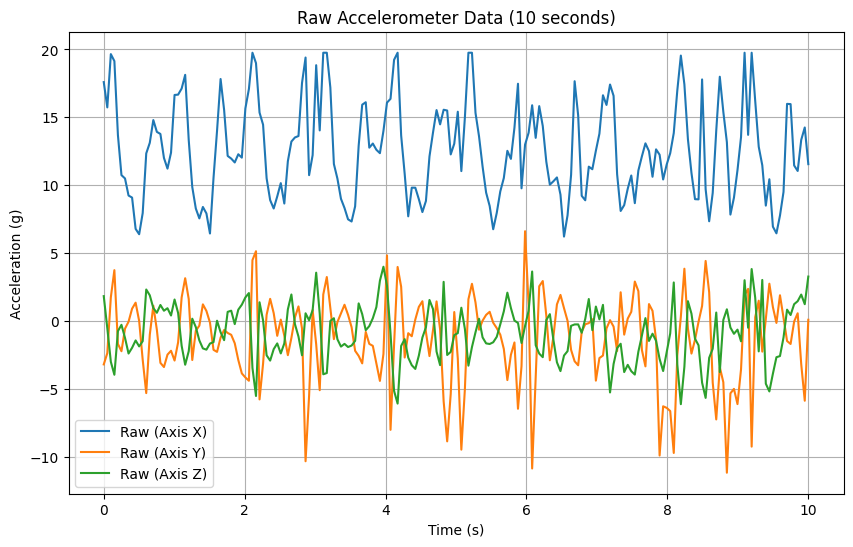

In [ ]:
import matplotlib.pyplot as plt

first_10_seconds = acc_raw

# Plot the data for one 10-second instance - before applying filter
time = np.linspace(0, 10, 200)  # Time vector for plotting

# Plot raw and filtered data
plt.figure(figsize=(10, 6))

for i in range(3):
    plt.plot(time, first_10_seconds[:, i], label=f'Raw (Axis {chr(88 + i)})')

plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Raw Accelerometer Data (10 seconds)')
plt.legend()
plt.grid(True)
plt.show()

## Defining filter for Accelerometer Data

This is a first-order low-pass filter.

In [ ]:
def first_order_lowpass_filter(data, cut_off_freq=0.5, sampling_freq=20):
    """
    Apply a first-order low-pass filter to the input data.

    Args:
    - data (numpy.ndarray): Input data array of shape (num_instances, num_samples_per_instance, num_axes).
    - cut_off_freq (float): Cut-off frequency of the low-pass filter in Hz.
    - sampling_freq (float): Sampling frequency of the input data in Hz.

    Returns:
    - numpy.ndarray: Filtered data array of the same shape as the input data.
    """

    # Calculate filter coefficient
    alpha = np.exp(-2 * np.pi * cut_off_freq / sampling_freq)  # 0.855

    # Initialize filtered data array
    filtered_data_all = np.zeros_like(data)

    # Apply filter to each axis of each instance separately
    for i in range(len(data)):
        for j in range(data.shape[1]):
            if j == 0:
                filtered_data_all[i, j] = data[i, j]
            else:
                filtered_data_all[i, j] = alpha * data[i, j] + (1 - alpha) * filtered_data_all[i, j - 1]

    return filtered_data_all

## Visualizing Filtered Data

In [ ]:
# Define filter parameters
cut_off_freq = 0.5  # Hz
sampling_freq = 20  # Hz

# Calculate filter coefficient
alpha = np.exp(-2 * np.pi * cut_off_freq / sampling_freq)

# Initialize filtered data array
filtered_data = np.zeros_like(first_10_seconds)

# Apply filter to each axis of each instance
current_index = 0
for i in first_10_seconds:
  if np.array_equal(i, first_10_seconds[0]):
    filtered_data[0] = first_10_seconds[0]
    current_index += 1
  else:
    filtered_data[current_index] = alpha * i + (1 - alpha) * filtered_data[current_index-1]
    current_index += 1

print("Un-Filtered data values")
print(first_10_seconds[20])
print("Filtered data values:")
print(filtered_data[20])

Un-Filtered data values
[16.649279  -2.918831   1.5779285]
Filtered data values:
[16.00986377 -2.82259443  1.41761997]


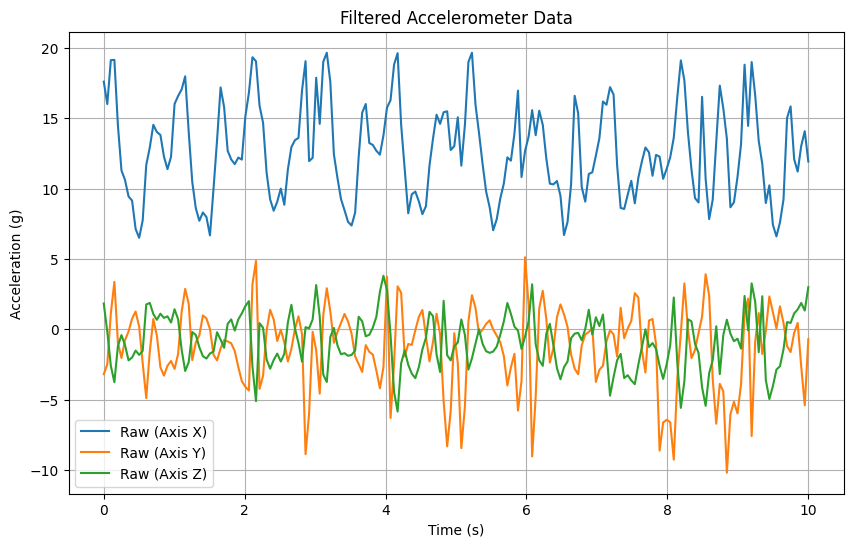

In [ ]:
# Plot the data for one 10-second instance - after applying filter
time = np.linspace(0, 10, 200)  # Time vector for plotting

# Plot raw and filtered data
plt.figure(figsize=(10, 6))

for i in range(3):
    plt.plot(time, filtered_data[:, i], label=f'Raw (Axis {chr(88 + i)})')

plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.title('Filtered Accelerometer Data')
plt.legend()
plt.grid(True)
plt.show()

Comparing the mean of values across each axis can be a simple way to check the effectiveness of the filter.

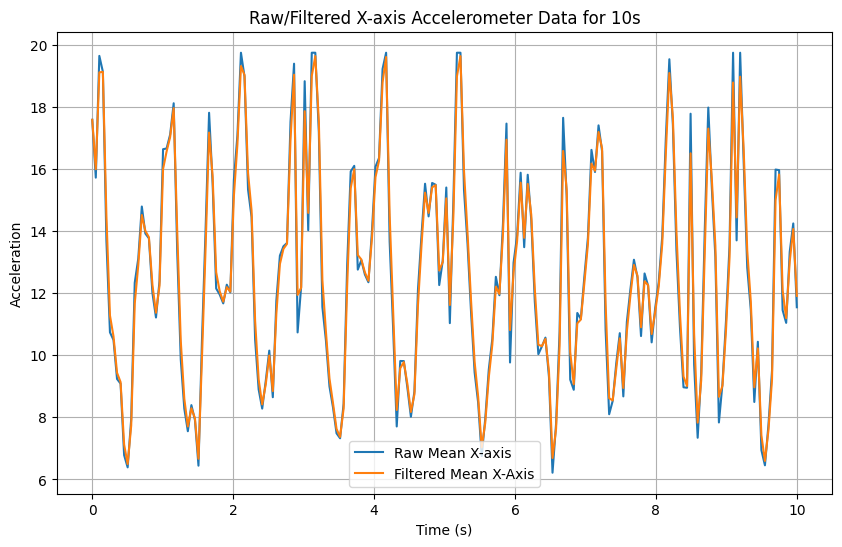

In [ ]:
# Compute the mean across each axis and compare
plt.figure(figsize=(10, 6))
plt.plot(time, first_10_seconds[:, 0], label='Raw Mean X-axis')
plt.plot(time, filtered_data[:, 0], label='Filtered Mean X-Axis')

plt.title('Raw/Filtered X-axis Accelerometer Data for 10s')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()

## Applying Filter to Entire Dataset

In [ ]:
# Combine the values from both acc and gyro into one timestamp
def combine_data(acc_data, gyro_data):
  # Current format {(Timestamp): [[sensorX, sensorY, sensorZ], [sensorX, sensorY, sensorZ] ... 198 ]}
  # Both dictionaries has the same key (Timestamp).

  combined_map = {}
  for key, value in acc_data.items():
    acc_values = acc_data[key]
    gyro_values = gyro_data[key]

    # Put the data through the filter before combining the Acc and Gyro values
    acc_raw = extract_sensor_data(acc_values)
    gyro_raw = extract_sensor_data(gyro_values)

    acc_filtered = first_order_lowpass_filter(acc_raw)
    gyro_filtered = first_order_lowpass_filter(gyro_raw)

    #create an empty array for each timestep. and then add the combined data to that array
    combined_map[key] = []

    for x_index, x_value in enumerate(acc_values):
      #check if there is a corresponding timestamp in the gyro_values for each acc_value
      for y_index, y_value in enumerate(gyro_values):
        x_value[2] = x_value[2]
        # if the timestamps are equal create an array with both the values
        array_all = [acc_filtered[x_index][0], acc_filtered[x_index][1], acc_filtered[x_index][2], gyro_filtered[y_index][0], gyro_filtered[y_index][1], gyro_filtered[y_index][2]]
        combined_map[key].append(array_all)
        break

  return combined_map

In [ ]:
# To store the pre-processed data
PRE_PROCESSED_DATASET = {}

In [ ]:
for key,value in tqdm(WISDM.items(), desc='Filtering and Processing Data', total=len(WISDM)):
  processed_data = combine_data(value[0], value[1])
  PRE_PROCESSED_DATASET[key] = processed_data

Filtering and Processing Data:   0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
print(len(PRE_PROCESSED_DATASET['1600']))

17


In [ ]:
sample_acc_data = PRE_PROCESSED_DATASET['1600']
print(sample_acc_data)
first_key, first_value = next(iter(sample_acc_data.items()))

{90430000000000: [[17.597382, -0.18000653861430393, 1.5351898294394672, 0.3712907, -0.47094222328832225, 0.470513908126569], [15.7323, 0.25685267198655115, -0.41678490185351214, 0.3712907, -0.47094222328832225, 0.470513908126569], [19.65879, 4.349083256865536, -1.9397089574501123, 0.3712907, -0.47094222328832225, 0.470513908126569], [19.146431, 5.981111269896095, -2.5209392378962594, 0.3712907, -0.47094222328832225, 0.470513908126569], [13.692439, 0.5414429692419029, -0.5636634834133892, 0.3712907, -0.47094222328832225, 0.470513908126569], [10.742783, -0.3456731399488453, -0.29566105490523553, 0.3712907, -0.47094222328832225, 0.470513908126569], [10.498574, 1.0388702764192397, -0.912866720655628, 0.3712907, -0.47094222328832225, 0.470513908126569], [9.239224, 1.291640517982883, -1.8644234982225327, 0.3712907, -0.47094222328832225, 0.470513908126569], [9.088389, 2.092275296940494, -1.387914018994598, 0.3712907, -0.47094222328832225, 0.470513908126569], [6.7827735, 2.13566333357032, -0.9

# Creating Pairs

In [ ]:
total_dataset = []
total_labels = []

In [ ]:
import numpy as np
from itertools import combinations
from itertools import product
import random

def create_positive_pairs(data):
  """ Create pairs of data extracted from the same same person.

  Arguments:
      data: list of acc and gyro data without any timestamps (Shape: 17,200,6)

  Returns:
      Two lists, one containing the pairs of data (Shape: 136, 2, 200, 6).
      Another (Shape: 136) containing the labels that indicate its a positive pair
  """

  # Generate combinations of the indices of the first dimension (17 arrays)
  combination_indices = combinations(data, 2)

  # Format the result
  positive_pairs = [list(p) for p in combination_indices]

  return np.array(positive_pairs), np.ones(136).astype("float32")



# Now we have 136 positive pairs that needs to be balanced with negative pairs
def create_negative_pairs(dataset1, dataset2):
  """ Create pairs of data extracted from two different people.

  Arguments: 2 lists containing Acc and Gyro data without timestamps (Shape: 17, 200,6)

  Returns: Two lists, one containing the pairs of data (Shape: 136, 2, 200, 6).
      Another (Shape: 136) containing the labels that indicate its a NEGATIVE pair
  """

  array_products = product(dataset1, dataset2)

  negative_pairs = [list(comb) for comb in array_products]

  # There will be 289 combinations that indicate negative pairs
  # We need to randomly drop combinations to mitigate class imbalance

  num_to_drop = 153 # 289 - 136
  indices_to_drop = random.sample(range(len(negative_pairs)), num_to_drop)

  for i in sorted(indices_to_drop, reverse=True):
    del negative_pairs[i]

  return np.array(negative_pairs), np.zeros(136).astype("float32")

In [ ]:
from tqdm.notebook import trange

keys = list(PRE_PROCESSED_DATASET.keys())

for index in trange(len(keys), desc = "Creating Pairs"):
    key = keys[index]
    all_sensor_data_for_subject = PRE_PROCESSED_DATASET[key]

    # Ommiting the last subject's data to mitigate class imbalance
    if index < 50:
      # Creating Positive pairs using the current index
      values_array_1 = [value for value in all_sensor_data_for_subject.values()]
      positive_pairs, positive_labels = create_positive_pairs(values_array_1)

      for pair, label in zip(positive_pairs, positive_labels):
        total_dataset.append(pair)
        total_labels.append(label)

      # Access next key and value using index to create negative pairs
      next_key = keys[index + 1]
      next_value = PRE_PROCESSED_DATASET[next_key]
      values_array_2 = [value for value in next_value.values()]
      negative_pairs, negative_labels = create_negative_pairs(values_array_1, values_array_2)

      for negative_pair, negative_label in zip(negative_pairs, negative_labels):
        total_dataset.append(negative_pair)
        total_labels.append(negative_label)

Creating Pairs:   0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
dataset_np = np.array(total_dataset)
print(dataset_np.shape)

labels_np = np.array(total_labels)
print(labels_np.shape)

(13600, 2, 200, 6)
(13600,)


## Defining the Train, Validation and Test Splits

Train - 70% (9520 Pairs)
Valdiation - 10% (1360 Pairs)
Test - 20% (2760 Pairs)

In [ ]:
from sklearn.model_selection import train_test_split
import random

# Shuffle pairs and labels, so that the model does not lean any patterns
# Combine pairs and labels
combined_dataset = list(zip(total_dataset, total_labels))

# Shuffle the combined data
random.shuffle(combined_dataset)

# Unpack the shuffled data back into pairs and labels
shuffled_pairs, shuffled_labels = zip(*combined_dataset)

print(len(shuffled_pairs))

# Split the dataset into training set and holdout set
X_train, X_holdout, y_train, y_holdout = train_test_split(shuffled_pairs, shuffled_labels, test_size=0.3, random_state=42)

# Further split the holdout set into validation set and test set
X_validation, X_test, y_validation, y_test = train_test_split(X_holdout, y_holdout, test_size=0.2, random_state=42)

print("Number of training data sets: ", len(X_train))
print("Each set has an array of length: ", len(X_train[0]))
print("One of those two elements in the array contain", len(X_train[0][0]), "data points (20hz polling rate, 10 seconds of data).")
print("Each data point has", len(X_train[0][0][0]), "elements. 3 accelerometer values and 3 gyroscope values")

train_pairs = np.array(X_train)
val_pairs = np.array(X_validation)

train_labels = np.array(y_train)
print(train_labels)
val_labels = np.array(y_validation)

print(train_labels.shape)

test_pairs = np.array(X_test)
test_labels = np.array(y_test)

13600
Number of training data sets:  9520
Each set has an array of length:  2
One of those two elements in the array contain 200 data points (20hz polling rate, 10 seconds of data).
Each data point has 6 elements. 3 accelerometer values and 3 gyroscope values
[0. 0. 0. ... 0. 1. 1.]
(9520,)


In [ ]:
X_train_1 = train_pairs[:, 0]
X_train_2 = train_pairs[:, 1]

print(X_train_1.shape)
print(X_train_2.shape)

X_val_1 = val_pairs[:, 0]
X_val_2 = val_pairs[:, 1]

X_test_1 = test_pairs[:, 0]
X_test_2 = test_pairs[:, 1]

(9520, 200, 6)
(9520, 200, 6)


In [ ]:
# Save .npy files for easy access to the dataset in the future
# Training numpy INPUTS
np.save('/content/drive/MyDrive/Implementation/dataset_preprocessed/X_train_1.npy', X_train_1)
np.save('/content/drive/MyDrive/Implementation/dataset_preprocessed/X_train_2.npy', X_train_2)
np.save('/content/drive/MyDrive/Implementation/dataset_preprocessed/train_labels.npy', train_labels)

# Validation numPy inputs
np.save('/content/drive/MyDrive/Implementation/dataset_preprocessed/X_val_1.npy', X_val_1)
np.save('/content/drive/MyDrive/Implementation/dataset_preprocessed/X_val_2.npy', X_val_2)
np.save('/content/drive/MyDrive/Implementation/dataset_preprocessed/val_labels.npy', val_labels)

# Testing numpy inputs
np.save('/content/drive/MyDrive/Implementation/dataset_preprocessed/X_test_1.npy', X_test_1)
np.save('/content/drive/MyDrive/Implementation/dataset_preprocessed/X_test_2.npy', X_test_2)
np.save('/content/drive/MyDrive/Implementation/dataset_preprocessed/test_labels.npy', test_labels)

# LSTM Model Architecture

*SOURCE: *(https://keras.io/examples/vision/siamese_contrastive/#define-the-contrastive-loss)

## Defining the Contrastive Loss Function

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

''' A Contrastive Loss funtion provided by Keras (https://keras.io/examples/vision/siamese_contrastive/#define-the-contrastive-loss)'''

def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) + true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - (y_pred), 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

## Model Architecture

In [ ]:
input = tf.keras.layers.Input((200,6))
x = tf.keras.layers.LSTM(512, return_sequences=True)(input)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
x = tf.keras.layers.LSTM(128)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

embedding_network = tf.keras.Model(input, x)

input_1 = tf.keras.layers.Input((200,6))
input_2 = tf.keras.layers.Input((200,6))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = tf.keras.layers.Dot(axes=1, normalize = True)([tower_1, tower_2])

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(merge_layer)

keras_siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [ ]:
keras_siamese.compile(loss=loss(margin=1), optimizer="RMSprop", metrics=["accuracy"])
keras_siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 6)]             0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 200, 6)]             0         []                            
                                                                                                  
 model (Functional)          (None, 64)                   2072256   ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 dot (Dot)                   (None, 1)                    0         ['model[0][0]',         

# Model Training

In [ ]:
from datetime import datetime
import pytz

# Specify Sri Lanka timezone
sri_lanka_timezone = pytz.timezone('Asia/Colombo')

# Get the current time in UTC
utc_now = datetime.utcnow()

# Convert the UTC time to Sri Lanka's local time
local_time = utc_now.replace(tzinfo=pytz.utc).astimezone(sri_lanka_timezone)

# Format the local time as a string
formatted_local_time = local_time.strftime("%Y-%m-%d_%H:%M")

print("Formatted Local Time in Sri Lanka:", formatted_local_time)

Formatted Local Time in Sri Lanka: 2024-03-24_21:00


In [ ]:
import os

checkpoint_dir = '/content/drive/MyDrive/Implementation/training_checkpoints'

# Define checkpoint filepath
checkpoint_path = os.path.join(checkpoint_dir, f'{formatted_local_time}_cp.ckpt')

print("Checkpoint Path:", checkpoint_path)

Checkpoint Path: /content/drive/MyDrive/Implementation/training_checkpoints/2024-03-24_21:00_cp.ckpt


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback to save weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)

In [ ]:
# Train the model from a saved checkpoint
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

print("Last Checkpoint: ", latest_checkpoint)

if latest_checkpoint:  # If a checkpoint exists
    keras_siamese.load_weights(latest_checkpoint)
    print('Loaded weights from checkpoint:', latest_checkpoint)
else:
    print('No checkpoint found. Starting training from scratch.')

Last Checkpoint:  /content/drive/MyDrive/Implementation/training_checkpoints/2024-03-19_09:59_cp.ckpt
Loaded weights from checkpoint: /content/drive/MyDrive/Implementation/training_checkpoints/2024-03-19_09:59_cp.ckpt


In [ ]:
history = keras_siamese.fit(
    [X_train_1, X_train_2],  # Training pairs
    train_labels,  # Training labels
    epochs=15,  # Number of epochs
    batch_size=64,  # Batch size
    validation_data=([X_val_1, X_val_2], val_labels),  # Validation data
    callbacks = [checkpoint_callback]
)

Epoch 1/15
149/149 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.8534 
Epoch 1: val_loss improved from inf to 0.14464, saving model to /content/drive/MyDrive/Implementation/training_checkpoints/2024-03-24_21:00_cp.ckpt
149/149 [==============================] - 2166s 14s/step - loss: 0.1352 - accuracy: 0.8534 - val_loss: 0.1446 - val_accuracy: 0.8416
Epoch 2/15
149/149 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.8839 
Epoch 2: val_loss improved from 0.14464 to 0.11107, saving model to /content/drive/MyDrive/Implementation/training_checkpoints/2024-03-24_21:00_cp.ckpt
149/149 [==============================] - 2240s 15s/step - loss: 0.1183 - accuracy: 0.8839 - val_loss: 0.1111 - val_accuracy: 0.8891
Epoch 3/15
149/149 [==============================] - ETA: 0s - loss: 0.1249 - accuracy: 0.8638 
Epoch 3: val_loss did not improve from 0.11107
149/149 [==============================] - 2254s 15s/step - loss: 0.1249 - accuracy: 0.8638 - 

# Save and Export Model

The Model is loaded from the saved weights in the evaluation notebook corresponding to this specifc model (Also contains logic for quantization, conversion and exporting).